In [48]:
#Import libraries
import os
import numpy as np
import pandas as pd
pd.options.display.max_rows = 6
pd.options.display.max_columns = 13

import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

In [49]:
#Set working directory

os.chdir("/Users/davidwells/Dropbox/Statistics/weight_time/data")
os.getcwd()

'/Users/davidwells/Dropbox/Statistics/weight_time/data'

In [50]:
################################
#                              #
#      Data preprocessing      #
#                              #
################################

#Load data.
data = pd.read_csv("rawdata/mongoose WEIGHTS.csv")
lhdata = pd.read_csv("rawdata/lhdata_march_2019.csv")

#Remove stupid named individuals.
bad_id = ["UM PUP", "UM PUP1", "UM PUP2", "UM PUP3", "UM AD", "UM F", "UM SUB", "UMSUB", "UNK", "", "BP375", "BP372"]
lhdata = lhdata[-lhdata.indiv.isin(bad_id)]

#Format dates.
#ALWAYS specify date format because its so easy to misinterpret, pandas assumes your data is mdy.
#Specifying also speeds up code.
data['date'] = pd.to_datetime(data['date'], format="%d/%m/%Y")
lhdata['date'] = pd.to_datetime(lhdata['date'], format="%Y-%m-%d")

#Sort by dates.
data = data.sort_values(by="date")

#Get birthdays.
born = lhdata[(lhdata.stend == "START") & (lhdata.code == "BORN")]

#Check duplicates
born[born.duplicated(subset="indiv")]

#Add age to data
data = pd.merge(data, born[['indiv', 'date']], how="left", on="indiv")
data.rename(columns={"date_x":"date","date_y":"dob"}, inplace=True)
data['age'] = data.date - data.dob
#age as numeric
data['agen'] = data['age'].dt.days

#Get month for seasonal effect
data['month'] = data.date.dt.strftime("%b")

#Remove NAs.
data = data.dropna(subset=["weight", "age"])

#Remove outright outliers.
data = data[(data.weight < 4000) & (data.age > pd.Timedelta(0))]

#For the R functions, working for timeseries requires at most a single point per day per individual.
#Therefore we have to remove any within day duplications of individuals.
#Data single record

iddate = data.duplicated(subset=['indiv','date'])
dsr = data[-iddate]

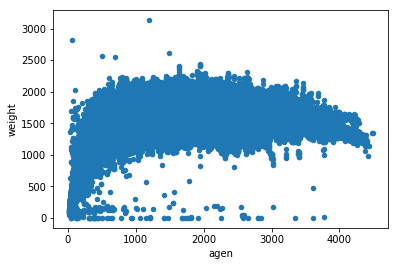

In [51]:
################################
#                              #
#       Data exploration       #
#                              #
################################
data.plot.scatter(x='agen',y="weight")


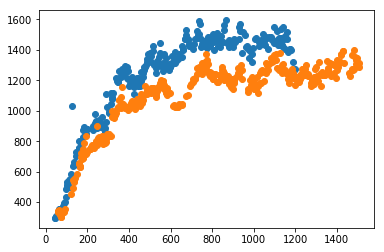

In [52]:
plt.plot("agen", "weight", "o", data=dsr[(dsr.indiv=="FM142") & (dsr.weight<1900)])
plt.plot("agen", "weight", "o", data=dsr[(dsr.indiv=="FM105") & (dsr.weight<1900)])

In [98]:
################################
#                              #
#        Split datasets        #
#                              #
################################

train = dsr[(dsr.date < "2010-01-01") & (dsr.date >= "2007-01-01")].sample(2000, replace=False)
#The training data is too large and slow for our purposes, subset it.
val = dsr[(dsr.date >= "2010-01-01") & (dsr.date <= "2013-01-01")]
test = dsr[(dsr.date > "2013-01-01")]


In [116]:
################################
#                              #
#          Fit models          #
#                              #
################################

#Super simple squared exponential/radial basis kernal
kx = RBF(10,(1e-2, 1e2))
gpx = GaussianProcessRegressor(kernel=kx, alpha=20, n_restarts_optimizer=9)

age=train.age.dt.days.values.reshape(-1,1)

gpx.fit(age, train.weight.values)


GaussianProcessRegressor(alpha=20, copy_X_train=True,
                         kernel=RBF(length_scale=50), n_restarts_optimizer=9,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)

In [117]:
#Constand and squared exponential kernel

kcx = ConstantKernel(1, (1e-2,1e2)) * RBF(10,(1e-2,1e2))
gpcx = GaussianProcessRegressor(kernel=kcx, alpha=10, n_restarts_optimizer=9)
gpcx.fit(age,train.weight.values)

GaussianProcessRegressor(alpha=10, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=9, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

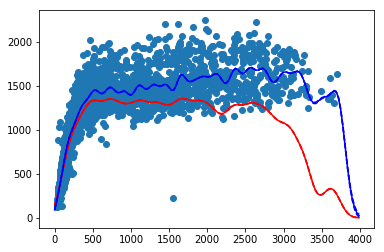

In [119]:
#pred, sigma = gpx.predict(age, return_std=True)
#Prediction age data
p_age = pd.Series(range(0,4000,30)).values.reshape(-1,1)

px, sigmax = gpx.predict(p_age, return_std=True)
pcx, sigmacx = gpcx.predict(p_age, return_std=True)

plt.plot(age, train.weight, "o")
plt.plot(p_age, px, "r-")
plt.plot(p_age, px+(1.96*sigmax), "r--")
plt.plot(p_age, px-(1.96*sigmax), "r--")
plt.plot(p_age, pcx, "b-")
plt.plot(p_age, pcx+(1.96*sigmacx), "b--")
plt.plot(p_age, pcx-(1.96*sigmacx), "b--")



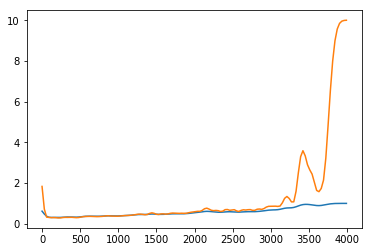

In [120]:
plt.plot(p_age,sigmax)
plt.plot(p_age,sigmacx)

In [186]:
#Fit gp to both age and date with a constant and exponential kernal
kadc = ConstantKernel(1, (1e-2,1e2))*RBF(10, (1e-2,1e3))
gpadc = GaussianProcessRegressor(kernel=kadc, alpha=10, n_restarts_optimizer=9)
gpadc.fit(train[['agen', 'daten']].values, train.weight.values)

GaussianProcessRegressor(alpha=10, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=9, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

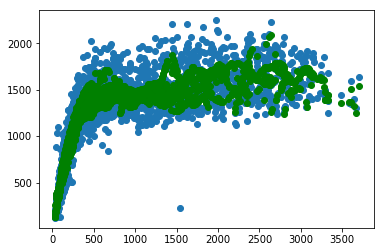

In [187]:
padc, sigmaadc = gpadc.predict(train[["agen", "daten"]].values, return_std=True)

plt.plot(age, train.weight, "o")
plt.plot(train.agen, padc, "go")

In [228]:
#Fit gp to both age and month with a constant and exponential kernal

am = pd.concat([train.agen, train.date.dt.month], axis=1)
am.columns = ["agen", "monthn"]


kamc = ConstantKernel(1, (1e-2,1e2))*RBF(10, (1e-2,1e3))
gpamc = GaussianProcessRegressor(kernel=kamc, alpha=10, n_restarts_optimizer=9)
gpamc.fit(am.values, train.weight.values)

GaussianProcessRegressor(alpha=10, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=9, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

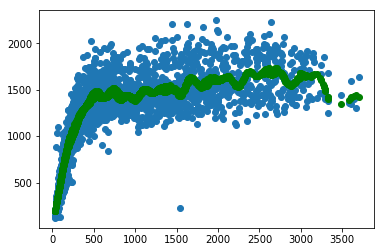

In [229]:
pamc, sigmaamc = gpamc.predict(am.values, return_std=True)

plt.plot(age, train.weight, "o")
plt.plot(am.agen, pamc, "go")

In [227]:
pd.concat([train.agen, train.date.dt.month], axis=1)

,agen,date
115437,1964.0,9
115238,1205.0,9
98044,1076.0,4
...,...,...
100971,82.0,7
105046,1474.0,10
117420,1860.0,11


In [ ]:
################################
#                              #
#            To do             #
#                              #
################################

#Incorporate alpha into gp for noise, do we have to estimate noise first?

#expand kernels

#Include month

#Why is the SD so small? seemingly capped at 1?